In [1]:
import torch
from pandas_datareader import data
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from models.LSTM import LSTM
#from utils.split_data import split_data
from sklearn.ensemble import RandomForestRegressor
from torch.nn import GRU
import matplotlib.pyplot as plt
import io
from itertools import product

def split_data(stock, lookback):
    data_raw = stock
    data = []
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])
        
    data = np.array(data)
    test_set_size = int(np.round(0.2*stock.shape[0]))
    train_set_size = stock.shape[0] - test_set_size

    x_train = data[:train_set_size, :-1,:]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1, :]
    y_test = data[train_set_size:, -1, :]
    
    return (x_train, y_train, x_test, y_test)

datapath = 'stock_data/0066.HK.csv'
startdate = "2022-01-01"
enddate = "2024-3-30"

 #####读取数据
data_to_be_predict = pd.read_csv(datapath)
data_to_be_predict['Date'] = pd.to_datetime(data_to_be_predict['Date'])
data_to_be_predict = data_to_be_predict.set_index('Date')
data_to_be_predict = data_to_be_predict.loc[startdate:enddate]

yf.pdr_override()
scaler = MinMaxScaler(feature_range=(-1, 1))  

print(data_to_be_predict)

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2022-01-03  41.950001  42.349998  41.900002  42.150002  39.278328  1761872
2022-01-04  42.099998  42.349998  41.500000  42.299999  39.418106  2910078
2022-01-05  42.349998  42.799999  42.250000  42.700001  39.790859  4416855
2022-01-06  42.750000  42.799999  42.000000  42.349998  39.464703  1457827
2022-01-07  42.250000  42.500000  41.900002  42.500000  39.604481  2066317
...               ...        ...        ...        ...        ...      ...
2024-03-22  25.900000  25.950001  25.299999  25.450001  25.450001  3367528
2024-03-25  25.500000  25.750000  25.250000  25.600000  25.600000  2579997
2024-03-26  26.000000  26.299999  25.600000  26.150000  26.150000  5201511
2024-03-27  26.100000  26.350000  25.850000  26.1500

In [2]:

    which_model = 'lstm'

    lookback = 50
    # Open = data_to_be_predict['Open'].values.reshape(-1,1)
    data_close = scaler.fit_transform(data_to_be_predict['Close'].values.reshape(-1,1))
    #print(data_close)            
    x_train, y_train, x_test, y_test = split_data(data_close, lookback)

    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)

    model = torch.load('pthfile/lstm_model_complete.pth')

    data_close = scaler.inverse_transform(data_close)

    test_pred = model(x_test)
    test_pred = pd.DataFrame((test_pred.detach().numpy()))
    train_pred = model(x_train)
    train_pred = pd.DataFrame((train_pred.detach().numpy()))

    trainPredictPlot=np.empty_like(data_close)
    trainPredictPlot[:,:]=np.nan
    trainPredictPlot[lookback:len(scaler.inverse_transform(train_pred))+lookback] = scaler.inverse_transform(train_pred)

    testPredictPlot=np.empty_like(data_close)
    testPredictPlot[:,:] = np.nan
    testPredictPlot[len(train_pred)+(lookback):len(data_close)] = scaler.inverse_transform(test_pred)

    ####整体predict序列
    whole_predict = np.empty_like(data_close)
    whole_predict[:,:] = np.nan
    whole_predict[lookback:len(scaler.inverse_transform(train_pred))+lookback] = scaler.inverse_transform(train_pred)
    whole_predict[len(train_pred)+(lookback):len(data_close)] = scaler.inverse_transform(test_pred)
    # actual = data_close[lookback:]

    whole_predict = pd.DataFrame({'Date':data_to_be_predict.index,'pred_close':whole_predict.flatten(),'act_close':data_to_be_predict['Close'],'open':data_to_be_predict['Open']})

    trainPredictPlot = pd.DataFrame({'Date':data_to_be_predict.index,'Close':trainPredictPlot.flatten()})
    testPredictPlot = pd.DataFrame({'Date':data_to_be_predict.index,'Close':testPredictPlot.flatten()})
    data_close = pd.DataFrame({'Date':data_to_be_predict.index,'Close':data_close.flatten()})

    mse_test = mean_squared_error(y_test_lstm.detach().numpy(),test_pred)
    mse_train = mean_squared_error(y_train_lstm.detach().numpy(),train_pred)
    
    print(testPredictPlot)
    print(trainPredictPlot)
    print(data_close)
    print(whole_predict)

    #return mse_train,mse_test,testPredictPlot,trainPredictPlot,data_close,whole_predict


          Date      Close
0   2022-01-03        NaN
1   2022-01-04        NaN
2   2022-01-05        NaN
3   2022-01-06        NaN
4   2022-01-07        NaN
..         ...        ...
545 2024-03-22  25.684784
546 2024-03-25  25.702879
547 2024-03-26  25.696663
548 2024-03-27  25.688812
549 2024-03-28  25.740170

[550 rows x 2 columns]
          Date  Close
0   2022-01-03    NaN
1   2022-01-04    NaN
2   2022-01-05    NaN
3   2022-01-06    NaN
4   2022-01-07    NaN
..         ...    ...
545 2024-03-22    NaN
546 2024-03-25    NaN
547 2024-03-26    NaN
548 2024-03-27    NaN
549 2024-03-28    NaN

[550 rows x 2 columns]
          Date      Close
0   2022-01-03  42.150002
1   2022-01-04  42.299999
2   2022-01-05  42.700001
3   2022-01-06  42.349998
4   2022-01-07  42.500000
..         ...        ...
545 2024-03-22  25.450001
546 2024-03-25  25.600000
547 2024-03-26  26.150000
548 2024-03-27  26.150000
549 2024-03-28  25.799999

[550 rows x 2 columns]
                 Date  pred_close  act_c

In [48]:
    lookback = 50
    # Open = data_to_be_predict['Open'].values.reshape(-1,1)
    data_close = scaler.fit_transform(data_to_be_predict['Close'].values.reshape(-1,1))
    #print(data_close)            
    x_train, y_train, x_test, y_test = split_data(data_close, lookback)

    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)

    model = torch.load('pthfile/gru_model_script.pth')

    data_close = scaler.inverse_transform(data_close)

    test_pred = model(x_test)
    test_pred = pd.DataFrame((test_pred.detach().numpy()))
    train_pred = model(x_train)
    train_pred = pd.DataFrame((train_pred.detach().numpy()))

    trainPredictPlot=np.empty_like(data_close)
    trainPredictPlot[:,:]=np.nan
    trainPredictPlot[lookback:len(scaler.inverse_transform(train_pred))+lookback] = scaler.inverse_transform(train_pred)

    testPredictPlot=np.empty_like(data_close)
    testPredictPlot[:,:] = np.nan
    testPredictPlot[len(train_pred)+(lookback):len(data_close)] = scaler.inverse_transform(test_pred)

    ####整体predict序列
    whole_predict = np.empty_like(data_close)
    whole_predict[:,:] = np.nan
    whole_predict[lookback:len(scaler.inverse_transform(train_pred))+lookback] = scaler.inverse_transform(train_pred)
    whole_predict[len(train_pred)+(lookback):len(data_close)] = scaler.inverse_transform(test_pred)
    # actual = data_close[lookback:]

    whole_predict = pd.DataFrame({'Date':data_to_be_predict.index,'pred_close':whole_predict.flatten(),'act_close':data_to_be_predict['Close'],'open':data_to_be_predict['Open']})

    trainPredictPlot = pd.DataFrame({'Date':data_to_be_predict.index,'Close':trainPredictPlot.flatten()})
    testPredictPlot = pd.DataFrame({'Date':data_to_be_predict.index,'Close':testPredictPlot.flatten()})
    data_close = pd.DataFrame({'Date':data_to_be_predict.index,'Close':data_close.flatten()})

    mse_test = mean_squared_error(y_test_lstm.detach().numpy(),test_pred)
    mse_train = mean_squared_error(y_train_lstm.detach().numpy(),train_pred)
    
    print(testPredictPlot)
    print(trainPredictPlot)
    print(data_close)
    print(whole_predict)
    print(mse_test)


          Date      Close
0   2022-01-03        NaN
1   2022-01-04        NaN
2   2022-01-05        NaN
3   2022-01-06        NaN
4   2022-01-07        NaN
..         ...        ...
545 2024-03-22  25.705744
546 2024-03-25  25.744890
547 2024-03-26  25.729864
548 2024-03-27  25.721462
549 2024-03-28  25.805502

[550 rows x 2 columns]
          Date  Close
0   2022-01-03    NaN
1   2022-01-04    NaN
2   2022-01-05    NaN
3   2022-01-06    NaN
4   2022-01-07    NaN
..         ...    ...
545 2024-03-22    NaN
546 2024-03-25    NaN
547 2024-03-26    NaN
548 2024-03-27    NaN
549 2024-03-28    NaN

[550 rows x 2 columns]
          Date      Close
0   2022-01-03  42.150002
1   2022-01-04  42.299999
2   2022-01-05  42.700001
3   2022-01-06  42.349998
4   2022-01-07  42.500000
..         ...        ...
545 2024-03-22  25.450001
546 2024-03-25  25.600000
547 2024-03-26  26.150000
548 2024-03-27  26.150000
549 2024-03-28  25.799999

[550 rows x 2 columns]
                 Date  pred_close  act_c

C:\Users\patty.hao\AppData\Local\anaconda3\envs\nlp_env\Lib\site-packages\torch\serialization.py:1006: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [20]:

    which_model = 'linearregression'

    # stock_data = data.get_data_yahoo('0066.HK', start="2010-01-01", end="2020-06-30").reset_index()
    data_to_be_predict_shift = data_to_be_predict.shift(1)
    data_to_be_predict_shift = data_to_be_predict_shift.iloc[1:]
    data_to_be_predict = data_to_be_predict.iloc[1:]
    predict_x = data_to_be_predict_shift[['Open', 'High', 'Low', 'Volume','Close']]
    predict_y = data_to_be_predict['Close']

    # print(predict_x)
    predict_y = predict_y.sort_index()
    predict_x = predict_x.sort_index()
    model = joblib.load('pthfile/linear_regression_model.joblib')
    predict_result = model.predict(predict_x)
    mse = mean_squared_error(predict_y, predict_result)

    pred = pd.DataFrame({'Date':pd.to_datetime(predict_x.index),'Close':predict_result})
    actual = pd.DataFrame({'Date':pd.to_datetime(predict_x.index),'Close':predict_y.values})

    whole_predict = pd.DataFrame({'Date':data_to_be_predict.index,'pred_close':predict_result.flatten(),'open':data_to_be_predict['Open'],'act_close':data_to_be_predict['Close']})
    ###trading 在开盘时，如果预测今天的close比开盘价高则买入

    #return mse,actual,pred,whole_predict

In [96]:
    
    lookback = 50
    # Open = data_to_be_predict['Open'].values.reshape(-1,1)
    data_close = scaler.fit_transform(data_to_be_predict['Close'].values.reshape(-1,1))
    #print(data_close)            
    x_train, y_train, x_test, y_test = split_data(data_close, lookback)

    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    print(x_test)
    y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    print(x_test)
    y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)

    

tensor([[[-0.4444],
         [-0.4286],
         [-0.4550],
         ...,
         [-0.4603],
         [-0.4233],
         [-0.4074]],

        [[-0.4286],
         [-0.4550],
         [-0.4603],
         ...,
         [-0.4233],
         [-0.4074],
         [-0.4550]],

        [[-0.4550],
         [-0.4603],
         [-0.5979],
         ...,
         [-0.4074],
         [-0.4550],
         [-0.5873]],

        ...,

        [[-0.6772],
         [-0.6825],
         [-0.7460],
         ...,
         [-0.9048],
         [-0.8730],
         [-0.9206]],

        [[-0.6825],
         [-0.7460],
         [-0.8730],
         ...,
         [-0.8730],
         [-0.9206],
         [-0.9048]],

        [[-0.7460],
         [-0.8730],
         [-0.8783],
         ...,
         [-0.9206],
         [-0.9048],
         [-0.8466]]])
tensor([[[-0.4444],
         [-0.4286],
         [-0.4550],
         ...,
         [-0.4603],
         [-0.4233],
         [-0.4074]],

        [[-0.4286],
         [-0.4

In [100]:
model = torch.load('pthfile/randomforest_model.pth')
data_close = scaler.inverse_transform(data_close)

test_pred = model.predict(x_test)
test_pred = pd.DataFrame((test_pred.detach().numpy()))
train_pred = model(x_train)
train_pred = pd.DataFrame((train_pred.detach().numpy()))    


ValueError: Found array with dim 3. Estimator expected <= 2.

In [2]:
lookback = 100
#mtr = scaler.fit_transform(data_to_be_predict.values)
mtr = scaler.fit_transform(data_to_be_predict['Close'].values.reshape(-1,1))
#print(mtr[1])

x_train, y_train, x_test, y_test = [], [], [], []
for i in range(len(mtr) - lookback):
    x_train.append(mtr[i:i+lookback])
    y_train.append(mtr[i+lookback])
for i in range(len(mtr) - lookback, len(mtr)):
    x_test.append(mtr[i-lookback:i])
    y_test.append(mtr[i])
#x_train[1]

x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
#x_train[1]

model = torch.load('pthfile/randomforest_model.pth')
        
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

test_pred = pd.DataFrame((test_pred.detach().numpy()))

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [3]:
lookback = 100

mtr = scaler.fit_transform(data_to_be_predict['Close'].values.reshape(-1, 1))

x_train, y_train, x_test, y_test = [], [], [], []
for i in range(len(mtr) - lookback):
    x_train.append(mtr[i:i+lookback])
    y_train.append(mtr[i+lookback])
for i in range(len(mtr) - lookback, len(mtr)):
    x_test.append(mtr[i-lookback:i])
    y_test.append(mtr[i])

x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

model = torch.load('pthfile/randomforest_model.pth')

train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

# 将缩放后的数据还原为原始数值
train_pred = scaler.inverse_transform(train_pred.reshape(-1, 1)).flatten()
test_pred = scaler.inverse_transform(test_pred.reshape(-1, 1)).flatten()
mtr = scaler.inverse_transform(mtr)

mse_train = mean_squared_error(y_train, train_pred)
mse_test = mean_squared_error(y_test, test_pred)

whole_predict = pd.DataFrame({'Date': data_to_be_predict.index, 'pred_close': np.concatenate([train_pred, test_pred]), 'act_close': data_to_be_predict['Close'], 'open': data_to_be_predict['Open']})

print(test_pred)
print(train_pred)
print(mtr)
print(whole_predict)

#return mse_train, mse_test, y_train, train_pred, y_test, test_pred, mtr, whole_predict

[30.12232933 30.4332237  30.25628254 29.60718386 29.60633108 29.40402747
 28.77348536 29.28796644 29.48926908 30.5095872  30.10823836 29.71180116
 30.02282395 29.77059512 29.77257124 29.85226462 29.73546187 29.56567572
 29.33086066 28.32922312 28.18756661 28.13457575 28.12881244 28.08152278
 28.36536993 28.13950579 28.12170469 28.19428576 28.45260159 28.56830304
 28.98277902 29.65882857 29.25113389 29.34354842 29.5073633  29.49816459
 29.54462636 29.59743229 30.13556304 30.29595598 29.84449361 28.67069686
 28.4680084  28.22801585 28.09894192 28.04775873 28.03582398 28.05307409
 28.04992169 28.05004466 27.4234919  26.0162106  25.83261976 25.81621999
 25.69652438 25.99992443 26.71206131 26.07552795 25.87263514 26.28666778
 25.69666843 25.12882509 25.12107042 25.70432849 25.74418986 26.15078512
 26.22166936 25.73267261 25.69845194 24.97202036 24.91554387 25.2013494
 25.10142437 25.90897173 26.70915077 27.10925614 26.32534109 26.34317344
 26.90685246 26.94260232 26.11688141 25.69068496 25.

In [4]:
lookback = 100

mtr = scaler.fit_transform(data_to_be_predict['Close'].values.reshape(-1, 1))

x_train, y_train, x_test, y_test = [], [], [], []
for i in range(len(mtr) - lookback):
    x_train.append(mtr[i:i+lookback])
    y_train.append(mtr[i+lookback])
for i in range(len(mtr) - lookback, len(mtr)):
    x_test.append(mtr[i-lookback:i])
    y_test.append(mtr[i])

x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)


In [5]:
which_model = 'randomforest'
lookback = 100
#mtr = scaler.fit_transform(data_to_be_predict.values)
mtr = scaler.fit_transform(data_to_be_predict['Close'].values.reshape(-1,1))
#print(mtr[1])

x_train, y_train, x_test, y_test = [], [], [], []
for i in range(len(mtr) - lookback):
    x_train.append(mtr[i:i+lookback])
    y_train.append(mtr[i+lookback])
for i in range(len(mtr) - lookback, len(mtr)):
    x_test.append(mtr[i-lookback:i])
    y_test.append(mtr[i])
#x_train[1]

x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
#x_train[1]

model = torch.load('pthfile/randomforest_model.pth')
        
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

mse_train = mean_squared_error(y_train, train_pred)
mse_test = mean_squared_error(y_test, test_pred)
        
whole_predict = pd.DataFrame({'Date':data_to_be_predict.index, 'pred_close': np.concatenate([train_pred, test_pred]), 'act_close':data_to_be_predict['Close'],'open':data_to_be_predict['Open']})

print(test_pred)
print(train_pred)
print(mtr)
print(whole_predict)

#return mse_train, mse_test, y_train, train_pred, y_test, test_pred, mtr, whole_predict

[-0.42620855 -0.39330967 -0.4120336  -0.4807213  -0.48081154 -0.50221934
 -0.56894338 -0.51450093 -0.49319906 -0.38522887 -0.42769966 -0.46965069
 -0.43673822 -0.4634291  -0.46321999 -0.45478683 -0.46714691 -0.4851137
 -0.50996186 -0.61595526 -0.63094537 -0.63655287 -0.63716274 -0.64216694
 -0.6121302  -0.63603117 -0.63791488 -0.63023435 -0.60289934 -0.59065579
 -0.5467959  -0.47525625 -0.51839855 -0.50861924 -0.49128433 -0.49225773
 -0.48734114 -0.48175321 -0.42480816 -0.40783536 -0.45560916 -0.57982047
 -0.60126898 -0.62666502 -0.64032364 -0.64573985 -0.64700279 -0.64517738
 -0.64551097 -0.64549796 -0.71179984 -0.86071852 -0.88014612 -0.88188155
 -0.89454775 -0.86244192 -0.78708351 -0.85444155 -0.87591169 -0.83209871
 -0.89453251 -0.95462176 -0.95544236 -0.89372192 -0.88950379 -0.84647783
 -0.83897685 -0.89072254 -0.89434378 -0.97121485 -0.9771912  -0.94694723
 -0.95752131 -0.87206655 -0.78739151 -0.74505231 -0.82800629 -0.82611927
 -0.76647069 -0.76268764 -0.85006552 -0.89516568 -0.

C:\Users\patty.hao\AppData\Local\anaconda3\envs\nlp_env\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.0.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


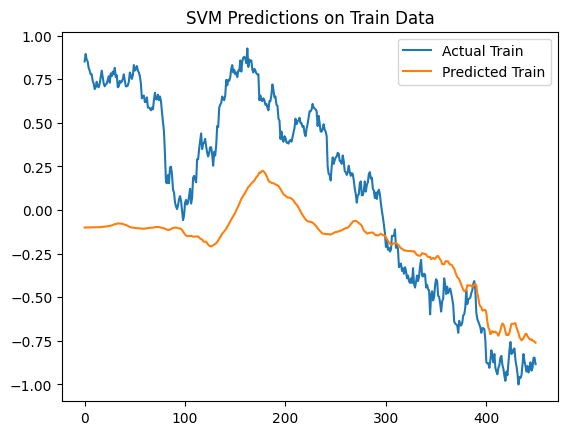

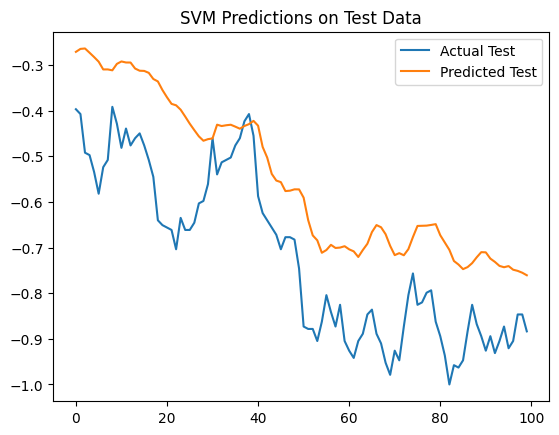

In [5]:

    which_model = 'svm'
    
    lookback = 100   
        
    #mtr = scaler.fit_transform(data_to_be_predict.values)
    mtr = scaler.fit_transform(data_to_be_predict['Close'].values.reshape(-1,1))
    # 构建训练集和测试集
    x_train, y_train, x_test, y_test = [], [], [], []
    for i in range(len(mtr) - lookback):
        x_train.append(mtr[i:i+lookback])
        y_train.append(mtr[i+lookback])
    for j in range(len(mtr) - lookback, len(mtr)):
        x_test.append(mtr[j-lookback:j])
        y_test.append(mtr[j])

    # 转换为 numpy 数组并重塑为二维数组
    x_train, y_train, x_test, y_test =  np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)

    # Load pre-trained SVM model
    model = torch.load('pthfile/svm_model.pth')

    # 进行预测
    train_pred = model.predict(x_train)
    test_pred = model.predict(x_test)
        
    # 计算均方误差
    mse_train = mean_squared_error(y_train, train_pred)
    mse_test = mean_squared_error(y_test, test_pred)

    # 绘制预测结果
    plt.plot(y_train, label='Actual Train')
    plt.plot(train_pred, label='Predicted Train')
    plt.legend()
    plt.title('SVM Predictions on Train Data')
    plt.show()
        
    plt.plot(y_test, label='Actual Test')
    plt.plot(test_pred, label='Predicted Test')
    plt.legend()
    plt.title('SVM Predictions on Test Data')
    plt.show()
        
    whole_predict = pd.DataFrame({'Date':data_to_be_predict.index, 'pred_close': np.concatenate([train_pred, test_pred]), 'open':data_to_be_predict['Open'],'act_close':data_to_be_predict['Close']})

    #return mse_train, mse_test, y_train, train_pred, y_test, test_pred, mtr, whole_predict


In [7]:

    which_model = 'gru'
    # 数据准备
    def prepare_data(data, lookback):
        x, y = [], []
        for i in range(len(data) - lookback):
            x.append(data[i:(i + lookback)])
            y.append(data[i + lookback])
        return np.array(x), np.array(y)

    # 加载数据
    scaled_data = scaler.fit_transform(data_to_be_predict['Close'].values.reshape(-1,1))
    #scaled_data = scaler.fit_transform(df.values)

    # 定义超参数
    lookback = 100

In [8]:
scaled_data

array([[ 0.84656115],
       [ 0.86243393],
       [ 0.90476214],
       [ 0.86772485],
       [ 0.88359803],
       [ 0.91005306],
       [ 0.87301618],
       [ 0.90476214],
       [ 0.92592624],
       [ 0.94179902],
       [ 0.91534399],
       [ 0.91005306],
       [ 0.91005306],
       [ 0.92592624],
       [ 0.94179902],
       [ 0.89947121],
       [ 0.857143  ],
       [ 0.86772485],
       [ 0.91534399],
       [ 0.87830711],
       [ 0.85185208],
       [ 0.92592624],
       [ 0.87830711],
       [ 0.88888896],
       [ 0.92592624],
       [ 0.93650809],
       [ 0.90476214],
       [ 0.91005306],
       [ 0.93121717],
       [ 0.91534399],
       [ 0.91534399],
       [ 0.91534399],
       [ 0.92592624],
       [ 0.84126982],
       [ 0.80952387],
       [ 0.76719606],
       [ 0.7354497 ],
       [ 0.66666687],
       [ 0.64550276],
       [ 0.59788363],
       [ 0.66137594],
       [ 0.65079369],
       [ 0.5925927 ],
       [ 0.64550276],
       [ 0.61904773],
       [ 0

In [9]:
    # 加载预训练的GRU模型
    loaded_model = torch.jit.load('pthfile/gru_model_script.pth')

In [10]:
loaded_model

RecursiveScriptModule(
  original_name=GRUModel
  (gru): RecursiveScriptModule(original_name=GRU)
  (fc): RecursiveScriptModule(original_name=Linear)
)

In [26]:
x_train, y_train, x_test, y_test = split_data(scaled_data, lookback)

In [13]:
# 准备训练集
train_data_scaled = scaler.transform(scaled_data)
x_train, y_train = prepare_data(train_data_scaled, lookback)
x_train = torch.from_numpy(x_train).type(torch.Tensor)  # 将 ndarray 转换为 Tensor

# 准备测试集
test_data_scaled = scaler.transform(scaled_data)
x_test, y_test = prepare_data(test_data_scaled, lookback)
x_test = torch.from_numpy(x_test).type(torch.Tensor)  # 将 ndarray 转换为 Tensor

In [31]:
x_train

tensor([[[ 0.8466],
         [ 0.8624],
         [ 0.9048],
         ...,
         [ 0.9365],
         [ 0.9312],
         [ 0.8677]],

        [[ 0.8624],
         [ 0.9048],
         [ 0.8677],
         ...,
         [ 0.9312],
         [ 0.8677],
         [ 0.8836]],

        [[ 0.9048],
         [ 0.8677],
         [ 0.8836],
         ...,
         [ 0.8677],
         [ 0.8836],
         [ 0.8519]],

        ...,

        [[-0.3810],
         [-0.3651],
         [-0.3704],
         ...,
         [-0.9577],
         [-0.9630],
         [-0.9471]],

        [[-0.3651],
         [-0.3704],
         [-0.4444],
         ...,
         [-0.9630],
         [-0.9471],
         [-0.8836]],

        [[-0.3704],
         [-0.4444],
         [-0.4286],
         ...,
         [-0.9471],
         [-0.8836],
         [-0.8254]]])

In [30]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)  # 将 ndarray 转换为 Tensor

In [33]:
x_test

tensor([[[-0.4444],
         [-0.4286],
         [-0.4550],
         [-0.4603],
         [-0.5979],
         [-0.4868],
         [-0.4656],
         [-0.5185],
         [-0.4974],
         [-0.4286],
         [-0.3968],
         [-0.4074],
         [-0.4921],
         [-0.4974],
         [-0.5344],
         [-0.5820],
         [-0.5238],
         [-0.5079],
         [-0.3915],
         [-0.4286],
         [-0.4815],
         [-0.4392],
         [-0.4762],
         [-0.4603],
         [-0.4497],
         [-0.4762],
         [-0.5079],
         [-0.5450],
         [-0.6402],
         [-0.6508],
         [-0.6561],
         [-0.6614],
         [-0.7037],
         [-0.6349],
         [-0.6614],
         [-0.6614],
         [-0.6455],
         [-0.6032],
         [-0.5979],
         [-0.5608],
         [-0.4603],
         [-0.5397],
         [-0.5132],
         [-0.5079],
         [-0.5026],
         [-0.4762],
         [-0.4603],
         [-0.4233],
         [-0.4074],
         [-0.4550],


In [32]:
x_test = torch.from_numpy(x_test).type(torch.Tensor)  # 将 ndarray 转换为 Tensor

In [34]:
    # 使用加载的模型进行预测
    loaded_model.eval()
    train_pred = loaded_model(x_train)
    train_pred = scaler.inverse_transform(train_pred.detach().numpy())
    test_pred = loaded_model(x_test)
    test_pred = scaler.inverse_transform(test_pred.detach().numpy())

In [43]:
train_pred

array([[41.95261 ],
       [41.812344],
       [41.665863],
       [41.62827 ],
       [41.57791 ],
       [41.517017],
       [41.40222 ],
       [41.270676],
       [41.128628],
       [41.01814 ],
       [40.878223],
       [40.73406 ],
       [40.565773],
       [40.449184],
       [40.434727],
       [40.408554],
       [40.37459 ],
       [40.38422 ],
       [40.47249 ],
       [40.631184],
       [40.706875],
       [40.67041 ],
       [40.57824 ],
       [40.5102  ],
       [40.47657 ],
       [40.500587],
       [40.575336],
       [40.58109 ],
       [40.65818 ],
       [40.710915],
       [40.79042 ],
       [40.830612],
       [40.91469 ],
       [40.89764 ],
       [40.8716  ],
       [40.72562 ],
       [40.586334],
       [40.54066 ],
       [40.517296],
       [40.515945],
       [40.550182],
       [40.634884],
       [40.648277],
       [40.57792 ],
       [40.497692],
       [40.44367 ],
       [40.449768],
       [40.569195],
       [40.66713 ],
       [40.695637],


In [44]:
test_pred

array([[25.783438],
       [25.842123],
       [25.808496],
       [25.793934],
       [25.732738],
       [25.705746],
       [25.74489 ],
       [25.729864],
       [25.721462],
       [25.805502]], dtype=float32)

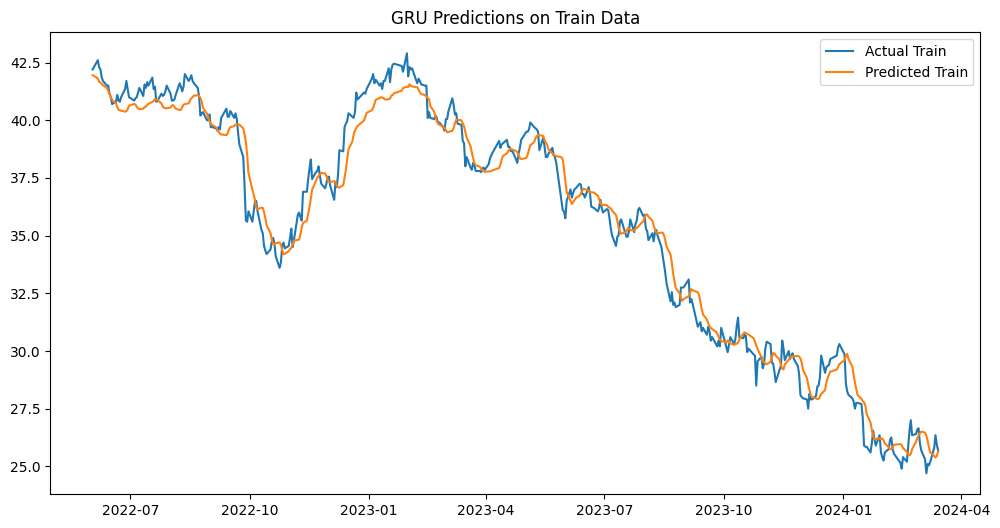

ValueError: x and y must have same first dimension, but have shapes (450,) and (10, 1)

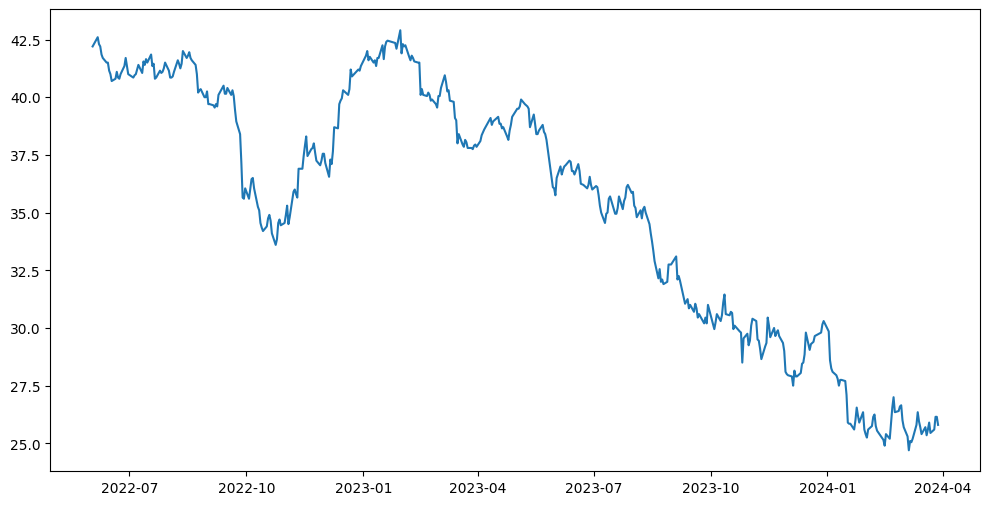

In [45]:
# 绘制训练集预测结果
plt.figure(figsize=(12, 6))
plt.plot(data_to_be_predict.index[lookback:len(train_pred) + lookback], data_to_be_predict['Close'][lookback:len(train_pred) + lookback], label='Actual Train')
plt.plot(data_to_be_predict.index[lookback:len(train_pred) + lookback], train_pred, label='Predicted Train')
plt.legend()
plt.title('GRU Predictions on Train Data')
plt.show()

# 绘制测试集预测结果
plt.figure(figsize=(12, 6))
plt.plot(data_to_be_predict.index[lookback:], data_to_be_predict['Close'][lookback:], label='Actual Test')
plt.plot(data_to_be_predict.index[lookback:], test_pred, label='Predicted Test (GRU Model)')
plt.legend()
plt.title('GRU Predictions on Test Data')
plt.show()

In [38]:

    # 可视化预测结果
    # 绘制训练集预测结果
    plt.figure(figsize=(12, 6))
    plt.plot(scaled_data.index[lookback:len(train_pred) + lookback], scaled_data['Close'][lookback:len(train_pred) + lookback], label='Actual Train')
    plt.plot(scaled_data.index[lookback:len(train_pred) + lookback], train_pred, label='Predicted Train')
    plt.legend()
    plt.title('GRU Predictions on Train Data')
    plt.show()

        
    plt.figure(figsize=(12, 6))
    plt.plot(scaled_data.index[lookback:], scaled_data['Close'][lookback:], label='Actual Test')
    plt.plot(scaled_datadf.index[lookback:], test_pred, label='Predicted Test (GRU Model)')
    plt.legend()
    plt.title('GRU Predictions on Test Data')
    plt.show()

   

AttributeError: 'numpy.ndarray' object has no attribute 'index'

<Figure size 1200x600 with 0 Axes>

In [39]:
    # 计算均方误差
    mse_train = mean_squared_error(y_train, train_pred)
    mse_test = mean_squared_error(y_test, test_pred)#df['Close'][lookback:]
    # print('MSE ON TRAIN:', mse_train)
    # print('MSE ON TEST:', mse_test) 
        
    whole_predict = pd.DataFrame({'Date':data_to_be_predict.index, 'pred_close': np.concatenate([train_pred, test_pred]), 'open':data_to_be_predict['Open'],'act_close':data_to_be_predict['Close']})

    #return mse_train, mse_test, y_train, train_pred, y_test, test_pred, scaled_data, whole_predict

ValueError: Per-column arrays must each be 1-dimensional

In [41]:
    # 加载数据
def split_data(stock, lookback):
    data_raw = stock
    data = []
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])
        
    data = np.array(data)
    test_set_size = int(np.round(0.2*stock.shape[0]))
    train_set_size = stock.shape[0] - test_set_size

    x_train = data[:train_set_size, :-1,:]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1, :]
    y_test = data[train_set_size:, -1, :]
    
    return (x_train, y_train, x_test, y_test)

IndentationError: expected an indented block after function definition on line 2 (4058246614.py, line 3)

In [42]:

which_model = 'gru'
scaled_data = scaler.fit_transform(data_to_be_predict['Close'].values.reshape(-1,1))
    #scaled_data = scaler.fit_transform(df.values)

    # 定义超参数
lookback = 100
    
        # 加载预训练的GRU模型
loaded_model = torch.jit.load('pthfile/gru_model_script.pth')
    
x_train, y_train, x_test, y_test = split_data(scaled_data, lookback)
    
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
    
        # 使用加载的模型进行预测
loaded_model.eval()
train_pred = loaded_model(x_train)
train_pred = scaler.inverse_transform(train_pred.detach().numpy())
test_pred = loaded_model(x_test)
test_pred = scaler.inverse_transform(test_pred.detach().numpy())

In [1]:
from predict_v2 import predict
import pylab as plt
import pandas as pd
import joblib
import matplotlib.dates as mdates
from models.linear_regression import linearregression_train
import tushare as ts
from trading_strategy.machinelearning_trading import buy_and_sell_in_one_day
from trading_strategy.machinelearning_trading import buy_and_select_when_sell
from trading_strategy.machinelearning_trading import buy_and_sell_with_ma
from trading_strategy.technical_trading import double_moving_ave
from trading_strategy.technical_trading import single_moving_ave
from trading_strategy.technical_trading import Bollinger_Bands
import sys
import json

In [2]:
task_id = '1'
stock_id = '000001.SZ'
start = '2001-1-1'
end = '2024-1-1'
modelname = 'gru'
strategy = 'buy_and_sell_in_one_day'
balance = 100000
    

In [3]:
    
    # 初始化 tushare，替换 'your_token_here' 为你的 Tushare Token
    ts.set_token('a8a8aff322d10b48165a40f49b8fb2b8a899495fd652e40dbbcb241b')
    pro = ts.pro_api()


    # 下载股票数据
    df = pro.daily(ts_code=stock_id, start_date=start, end_date=end)
    df.rename(columns={'close': 'Close'}, inplace=True)
    df.rename(columns={'trade_date': 'Date'}, inplace=True)
    df.rename(columns={'open': 'Open'}, inplace=True)
    df.rename(columns={'high': 'High'}, inplace=True)
    df.rename(columns={'low': 'Low'}, inplace=True)
    df.rename(columns={'amount': 'Volume'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
    df.set_index('Date',inplace=True)
    df.sort_index(inplace=True)
    df.to_csv('stock_data.csv')

In [4]:
print(df)
datapath = 'stock_data.csv'

              ts_code   Open   High    Low  Close  pre_close  change  pct_chg  \
Date                                                                            
2001-01-02  000001.SZ  14.54  14.70  14.40  14.55      14.52    0.03   0.2100   
2001-01-03  000001.SZ  14.56  14.61  14.37  14.44      14.55   -0.11  -0.7600   
2001-01-04  000001.SZ  14.45  14.50  14.30  14.35      14.44   -0.09  -0.6200   
2001-01-05  000001.SZ  14.33  14.33  14.12  14.20      14.35   -0.15  -1.0500   
2001-01-08  000001.SZ  14.20  14.20  13.98  14.00      14.20   -0.20  -1.4100   
...               ...    ...    ...    ...    ...        ...     ...      ...   
2023-12-25  000001.SZ   9.18   9.20   9.14   9.19       9.20   -0.01  -0.1087   
2023-12-26  000001.SZ   9.19   9.20   9.07   9.10       9.19   -0.09  -0.9793   
2023-12-27  000001.SZ   9.10   9.13   9.02   9.12       9.10    0.02   0.2198   
2023-12-28  000001.SZ   9.11   9.47   9.08   9.45       9.12    0.33   3.6184   
2023-12-29  000001.SZ   9.42

In [6]:
    
    if modelname ==  'lstm':
        mse_train,mse_test,testPredictPlot,trainPredictPlot,data,whole_predict= predict('lstm',datapath = datapath,startdate = start,enddate = end)
    elif modelname ==  'linearregression':
        linearregression_train(datapath = datapath,startdate = start,enddate =end)
        mse,actual,pred,whole_predict = predict('linearregression',datapath = datapath,startdate = start,enddate = end)
    elif modelname ==  'randomforest':
        mse_train, mse_test, y_train, train_pred, y_test, test_pred, mtr, whole_predict = predict('randomforest',datapath = datapath,startdate = start,enddate = end)
    elif modelname ==  'svm':
        mse_train, mse_test, y_train, train_pred, y_test, test_pred, mtr, whole_predict = predict('svm',datapath = datapath,startdate = start,enddate = end)
    elif modelname ==  'gru':
        mse_train,mse_test,testPredictPlot,trainPredictPlot,data,whole_predict = predict('gru',datapath = datapath,startdate = start,enddate = end)

C:\Users\patty.hao\AppData\Local\anaconda3\envs\nlp_env\Lib\site-packages\torch\serialization.py:1006: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [7]:
whole_predict

,Date,pred_close,act_close,open
Date,,,,
2001-01-02,2001-01-02,NaN,14.55,14.54
2001-01-03,2001-01-03,NaN,14.44,14.56
2001-01-04,2001-01-04,NaN,14.35,14.45
2001-01-05,2001-01-05,NaN,14.20,14.33
2001-01-08,2001-01-08,NaN,14.00,14.20
...,...,...,...,...
2023-12-25,2023-12-25,9.231746,9.19,9.18
2023-12-26,2023-12-26,9.238460,9.10,9.19
2023-12-27,2023-12-27,9.249213,9.12,9.10


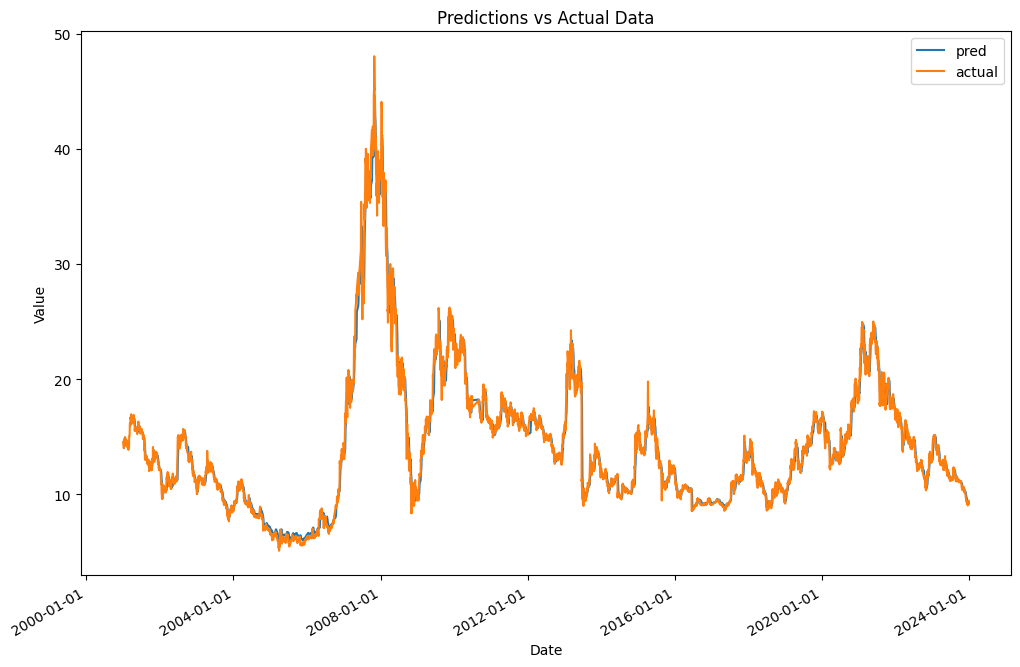

In [8]:
    
    plt.ioff()
    #####作prediction图并保存
    plt.figure(figsize=(12,8))

    # plt.plot(pd.to_datetime(data['Date']),data['Close'],label = 'data')
    # plt.plot(pd.to_datetime(testPredictPlot['Date']),testPredictPlot['Close'],label = 'test_pred')
    # plt.plot(pd.to_datetime(trainPredictPlot['Date']),trainPredictPlot['Close'],label = 'train_pred')
    
    plt.plot(pd.to_datetime(whole_predict['Date']),whole_predict['pred_close'],label = 'pred')
    plt.plot(pd.to_datetime(whole_predict['Date']),whole_predict['act_close'],label = 'actual')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xlabel('Date')
    plt.ylabel('Value')
    
    
    plt.gcf().autofmt_xdate()
    plt.title('Predictions vs Actual Data')
    plt.legend()
    plt.show()
    plt.savefig('prediction_'+task_id+'.jpg')
    plt.close()

In [9]:
    
    log_path = 'log_'+task_id+'.txt'
    ####strategy
    if strategy == 'buy_and_select_when_sell':
        yield_curve,final_balance,yield_rate,benchmark_yield = buy_and_select_when_sell(whole_predict,log_path,balance=balance) 

    elif strategy == 'buy_and_sell_in_one_day':
        yield_curve,final_balance,yield_rate,benchmark_yield = buy_and_sell_in_one_day(whole_predict,log_path,balance=balance)

    elif strategy == 'buy_and_sell_with_ma':
        yield_curve,final_balance,yield_rate,benchmark_yield = buy_and_sell_with_ma(whole_predict,log_path,balance=balance)

In [10]:
yield_curve

,balance,return,benchmark
Date,,,
2001-01-02,100000,0.0,0.0
2001-01-03,100000,0.0,-1.379725
2001-01-04,100000,0.0,-1.672394
2001-01-05,100000,0.0,-2.195017
2001-01-08,100000,0.0,-1.971036
...,...,...,...
2023-12-25,616216.62,0.224495,-0.016021
2023-12-26,610181.94,0.221845,-0.016288
2023-12-27,611522.98,0.222401,-0.016226


In [11]:
final_balance

634345.8199999995

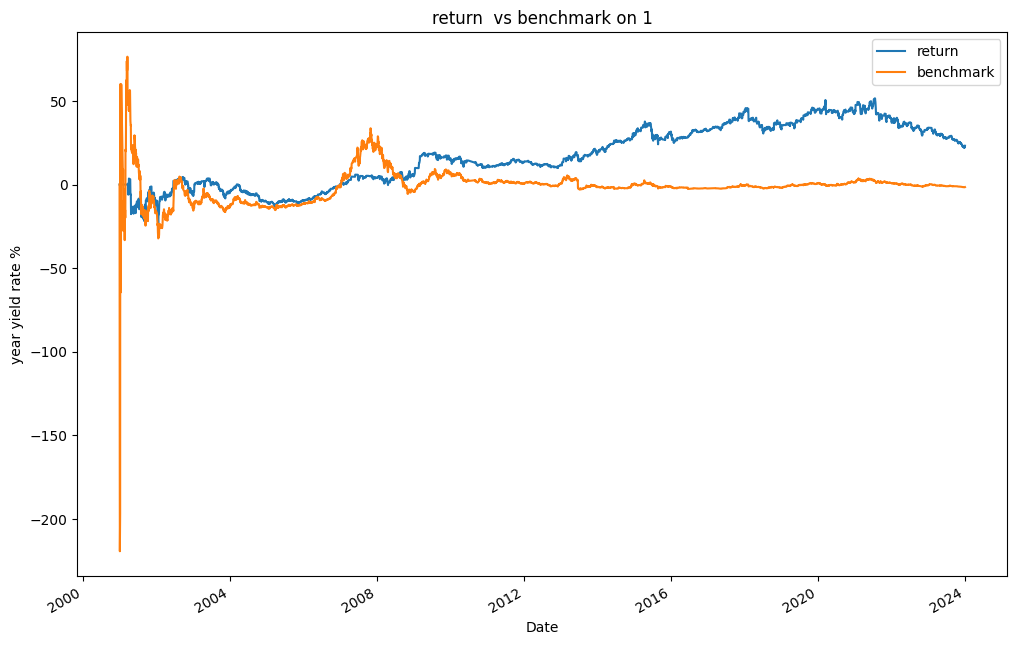

In [12]:
    
    # plt.ylim(-100,100)
    plt.figure(figsize=(12,8))
    plt.plot(yield_curve.index,yield_curve['return']*100,label = 'return')
    plt.plot(yield_curve.index,yield_curve['benchmark']*100,label = 'benchmark')

    plt.xlabel('Date')
    plt.ylabel('year yield rate %')
    

    plt.gcf().autofmt_xdate()
    plt.title('return  vs benchmark on '+task_id)
    plt.legend()
    plt.show()
    plt.savefig('return_rate_'+task_id+'.jpg')
    plt.close()
    result = {"预测图片":'prediction_'+task_id+'.jpg',
               "收益率图片": 'return_rate_'+task_id+'.jpg',
               "日志信息":'log/log_'+task_id+'.txt',
               "收益率":yield_rate,
               "基准收益率":benchmark_yield,
               "账户价值":final_balance}

In [13]:
print(result)

{'预测图片': 'prediction_1.jpg', '收益率图片': 'return_rate_1.jpg', '日志信息': 'log/log_1.txt', '收益率': 7690.084890185807, '基准收益率': -1.5417258095411166, '账户价值': 176993021.2000001}
